### Make Wave2Web DataFrames

This notebook will make the raw dataframes which can be used to predict reservoir levels. 

**approach**:
- get the geometries of the Pfafstetter Level 12 basins upstream of each reservoir
- use those geometries to query ERA5 weather and ECMWF forecast data and reduce over each upstream geometry
- assemble a full dataframe

In [6]:
import os
import matplotlib.pyplot as plt

import geopandas as gpd # geodataframe manipulation
import networkx as nx   # network traversal
import xarray as xr
import zarr

import rasterio as rio
from rasterio.features import rasterize
from skimage.measure import block_reduce

# we might want some dask for getting data
import dask
from dask.distributed import Client
client = Client(n_workers=13, threads_per_worker=1, memory_limit='4GB', dashboard_address=':8787')

# ... that's a big bag of tricks

We want to use the directed nature of the Pfafstetter basins to get all the upstream basins for each reservoir. We can use networkx for this.

In [4]:
root = os.getcwd() # set our root directory

### Get Upstream Geometries of each reservoir

In [16]:
# load our data
basins = gpd.read_file(os.path.join(root,'wave2web_data','hybas_as_lev12_v1c.shp'))
reservoirs = gpd.read_file(os.path.join(root,'wave2web_data','reservoirs.shp'))
ne = gpd.read_file(os.path.join(root,'wave2web_data','ne_10m_countries.gpkg'))   # natural earth so we can sensibly clip to India

In [18]:
# clip our basins to India
india = ne.loc[ne['ADMIN']=='India',:]

In [24]:
basins = basins[basins.intersects(india.geometry.unary_union)]

(11.5, 13.0)

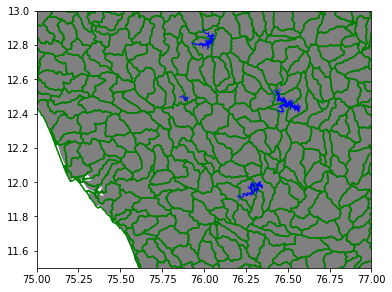

In [33]:
# visualise
fig, ax = plt.subplots(1,1,figsize=(6,6))
india.plot(ax=ax, color='gray', zorder=0)
basins.boundary.plot(ax=ax, color='g', zorder=1)
reservoirs.plot(ax=ax, color='b', zorder=2)
ax.set_xlim([75,77])
ax.set_ylim([11.5,13])

In [40]:
# set up our directed graph of Level 12 Pfafstetted basins
g = nx.DiGraph()
g.add_edges_from(basins[['HYBAS_ID','NEXT_DOWN']].to_records(index=False).tolist())

In [ ]:
g = nx.DiGraph()

g.add_edges_from([]) # list of a->b tuples

# get upstream nodes with tree search
upstream = [n for n in nx.traversal.bfs_tree(g, 2, reverse=True) if n != 2]

In [ ]:
# let's not do anything fancy just yet - just get the union of all the upstream basins.

In [ ]:
# some helper functions for when we are rounding to non-base 10 (e.g. 0.5deg lat/lon)
def baseround(x, base):
    return base * np.round(x/base)
def basefloor(x, base):
    return base * np.floor(x/base)
def baseceil(x, base):
    return base * np.ceil(x/base)